In [1]:
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import numpy as np, pandas as pd
pd.set_option('display.max_rows', 8)

from db_queries import get_outputs, get_ids
from gbd_mapping import causes

!date
!whoami

Mon Jul 29 19:55:25 PDT 2019
yongqx2


In [2]:
result_dir = '/ihme/costeffectiveness/results/sqlns/verification_and_validation/'

path_for_location = {'Bangladesh': result_dir + 'vv_bangladesh/2019_07_02_11_55_19',
                     'Burkina Faso': result_dir + 'vv_burkina_faso/2019_07_02_11_56_40',
                     'Ethiopia': result_dir + 'vv_ethiopia/2019_07_02_11_58_02',
                     'India': result_dir + 'vv_india/2019_07_02_11_58_29',
                     'Nigeria': result_dir + 'vv_nigeria/2019_07_02_11_58_49'}

cause_names = ['lower_respiratory_infections', 'measles', 'diarrheal_diseases',
               'protein_energy_malnutrition', 'dietary_iron_deficiency']

age_group_sort_dict = {'early_neonatal': 0, 'late_neonatal': 1, 'post_neonatal': 2, '1_to_4': 3}

In [3]:
def get_gbd_outputs(location_id, cause_names):
    ages = [2, 3, 4, 5]
    male, female, both = 1, 2, 3
    rate = 3
    dalys, ylds, ylls = 2, 3, 4
    
    cause_map = {c.gbd_id: c.name for c in causes if c.name in cause_names + ['all_causes']}

    gbd_outputs = get_outputs('cause', cause_id=list(cause_map.keys()), 
                              metric_id=[rate], measure_id=[dalys, ylls, ylds], 
                              sex_id = [male, female, both], age_group_id=ages,
                              location_id=location_id, gbd_round_id=5)


    gbd_outputs = gbd_outputs[['cause_id', 'age_group_name', 'measure_name', 'sex', 'val', 'upper', 'lower']]
    gbd_outputs['cause'] = gbd_outputs.cause_id.map(cause_map)
    gbd_outputs['measure'] = gbd_outputs.measure_name.map({'DALYs (Disability-Adjusted Life Years)':'dalys',
                                                           'YLLs (Years of Life Lost)': 'ylls',
                                                           'YLDs (Years Lived with Disability)': 'ylds'})
    gbd_outputs['age_group'] = gbd_outputs.age_group_name.str.replace(' ', '_').map(lambda x: x.lower())
    gbd_outputs = gbd_outputs.drop(columns=['cause_id', 'measure_name', 'age_group_name'])
    gbd_outputs[['val', 'upper', 'lower']] *= 100_000
    
    gbd = gbd_outputs.set_index(['cause', 'measure', 'sex']).sort_index().reset_index()
    
    return gbd

In [4]:
def load_and_aggregate(path):
    df = pd.read_hdf(path + '/output.hdf')
    g = df.groupby('input_draw').sum()
    return g

In [5]:
def get_year_from_template(template_string):
    return template_string.split('_in_')[1].split('_among')[0]

def get_sex_from_template(template_string):
    return template_string.split('_among_')[1].split('_in')[0].capitalize()

def get_age_group_from_template(template_string):
    return template_string.split('age_group_')[1]

In [6]:
def standardize_shape(data, measure, by_cause=True):
    extra_cols = ['cause'] if by_cause else []
    
    measure_data = data.loc[:, [c for c in data.columns if measure in c]]
    measure_data = measure_data.stack().reset_index().rename(columns={'level_1': 'label', 0: 'value'})
    if 'due_to' in measure:
        measure, cause = measure.split('_due_to_', 1)
        measure_data.loc[:, 'measure'] = measure
        measure_data.loc[:, 'cause'] = cause
    else:
        measure_data.loc[:, 'measure'] = measure
    
    measure_data.loc[:, 'year'] = measure_data.label.map(get_year_from_template)
    measure_data.loc[:, 'sex'] = measure_data.label.map(get_sex_from_template)
    measure_data.loc[:, 'age_group'] = measure_data.label.map(get_age_group_from_template)
    measure_data.drop(columns='label', inplace=True)
    
    time_aggregate = measure_data.groupby(extra_cols + ['sex', 'age_group', 'measure', 'input_draw']).value.sum().reset_index()
    time_aggregate = time_aggregate.loc[time_aggregate['age_group'].map(age_group_sort_dict).sort_values().index]
    time_aggregate = time_aggregate.set_index(['sex', 'input_draw']).sort_index().reset_index()
    
    return time_aggregate

In [7]:
def get_disaggregated_results(data, cause_names):
    ylds = []
    ylls = []
    for cause in cause_names:
        ylds.append(standardize_shape(data, f'ylds_due_to_{cause}'))
        if cause != 'iron_deficiency':
            ylls.append(standardize_shape(data, f'ylls_due_to_{cause}'))
    yld_data = pd.concat(ylds)
    yll_data = pd.concat(ylls)
    output = pd.concat([yld_data, yll_data])
    
    output['cause'] = output.cause.str.replace('iron_deficiency', 'dietary_iron_deficiency')
    
    return output

In [8]:
def make_plots(cause, results, gbd, location):
    
    result_data = results.loc[results.cause == cause]
    result_data['rate'] = result_data['value'] / result_data['person_time'] * 100_000
    means = result_data.groupby(['cause', 'sex', 'age_group', 'measure']).rate.mean().reset_index()
    means = means.loc[means['age_group'].map(age_group_sort_dict).sort_values().index]
    gbd_data = gbd.loc[(gbd.sex!= 'Both') & (gbd.cause == cause)]
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    clrs = sns.color_palette('husl', 2)

    for ax, measure in zip(axs, ['ylls', 'ylds']):
        measure_r = result_data[result_data.measure == measure]
        measure_m = means[means.measure == measure]
        measure_g = gbd_data[gbd_data.measure == measure]

        g1 = sns.catplot(x='age_group', y='rate', 
                         hue='sex', palette=clrs, alpha=0.2, 
                         ax=ax, data=measure_r)
        sns.scatterplot(x='age_group', y='rate', 
                        hue='sex', palette=clrs, 
                        s=300, marker='P', 
                        ax=ax, legend=False, data=measure_m)
        sns.lineplot(x='age_group', y='val', 
                     hue='sex', palette=clrs, linewidth=2,
                     ax=ax, data=measure_g, sort=False)

        for i, sex in enumerate(['Female', 'Male']):
            sex_g = measure_g[measure_g.sex == sex]
            ax.fill_between(sex_g.age_group, sex_g.upper, sex_g.lower, alpha=0.3, facecolor=clrs[i])

        ax.set_title(f'{location}, {measure.capitalize()} due to {cause}', fontsize=16)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_xlabel('Age group')
        ax.set_ylabel(f'{measure.capitalize()} per 100k PY')

        l = ax.legend(loc='upper right')
        labels = ['GBD Female', 'GBD Male', 'Simulation Female', 'Simulation Male']
        for text, label in zip(l.texts[1:], labels):
            text.set_text(label)

        plt.close(g1.fig)

In [9]:
def fill_df_w_na(data):
    causes = ['dietary_iron_deficiency']
    sexes = ['Female', 'Male']
    age_groups = data.age_group.unique()
    measures = ['ylls']
    draws = data.input_draw.unique()

    output_index = pd.MultiIndex.from_product([causes, sexes, age_groups, measures, draws], names=['cause', 'sex', 'age_group', 'measure', 'input_draw'])
    output = pd.DataFrame(np.nan, columns=['value', 'person_time'], index=output_index)
    
    return output.reset_index()

In [10]:
def plot_multiple_locations(my_dict, cause_names):
    
    location_id_table = get_ids('location')
    
    for location, path in my_dict.items():    
        r = load_and_aggregate(path)
        pt = standardize_shape(r, 'person_time', by_cause=False)
        df = get_disaggregated_results(r, cause_names[:-1] + ['iron_deficiency'])
        results = pd.merge(df, pt.drop(columns='measure').rename(columns={'value': 'person_time'}), on=['sex', 'age_group', 'input_draw'])
        t = fill_df_w_na(results)
        results = pd.concat([results, t])
        
        location_id = location_id_table.loc[location_id_table.location_name == location].location_id.values
        gbd = get_gbd_outputs(location_id, cause_names)
        
        with PdfPages(f'/home/j/Project/simulation_science/mnch/Interventions/sq-lns/validation/sq_lns_cause_specific_vv_in_{location}.pdf') as pdf:
            for cause in cause_names:
                make_plots(cause, results, gbd, location)
                pdf.savefig()

/share/code/yongqx2/miniconda/envs/sq_lns/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()
/share/code/yongqx2/miniconda/envs/sq_lns/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/share/code/yongqx2/miniconda/envs/sq_lns/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future versi

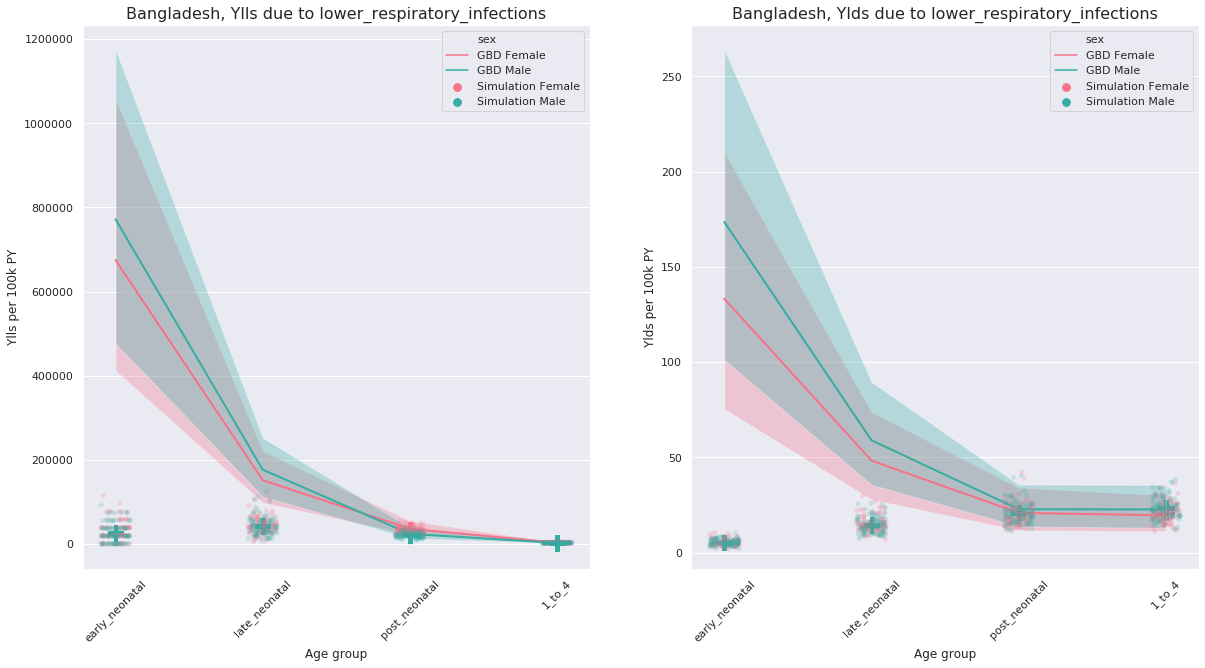

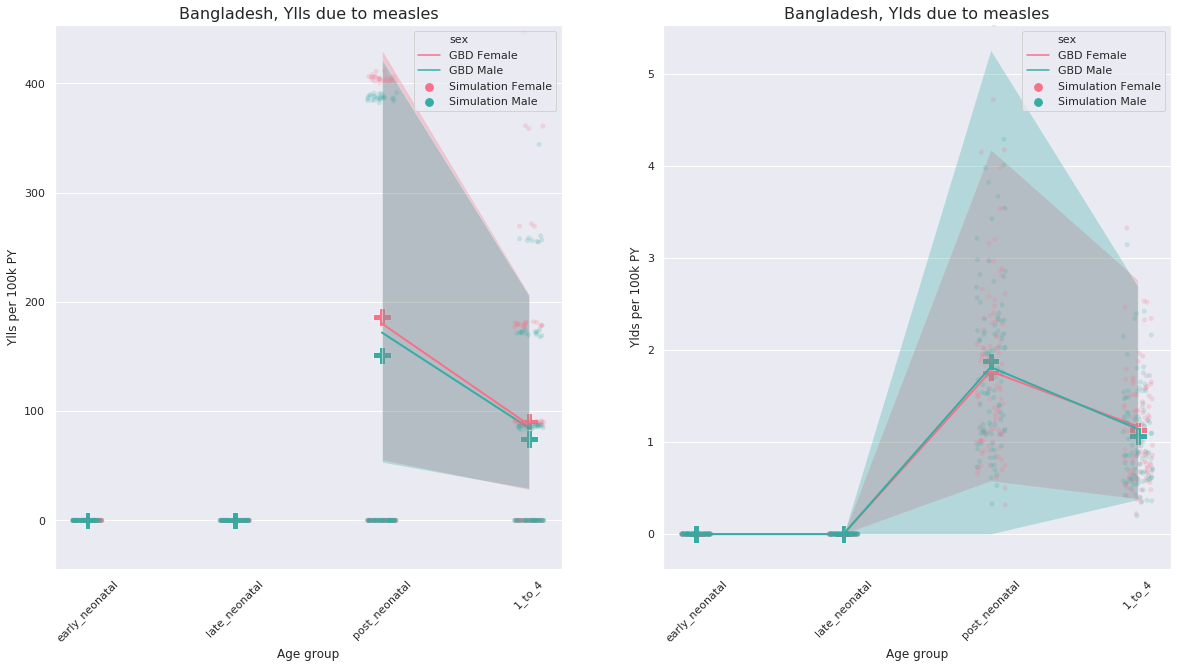

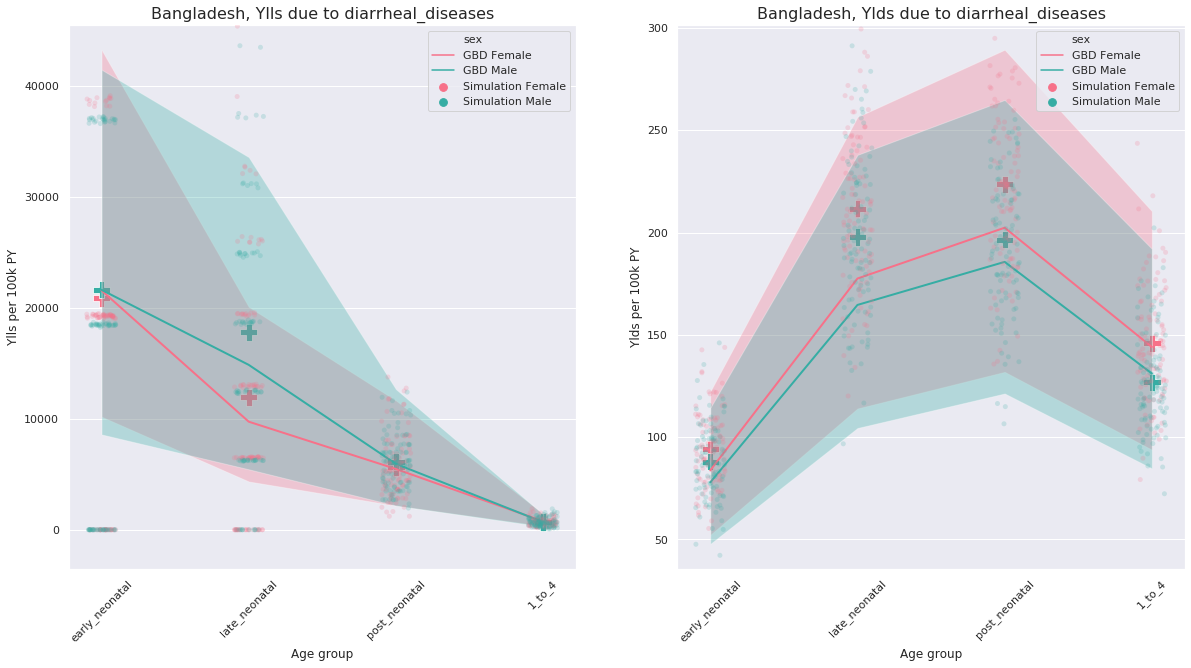

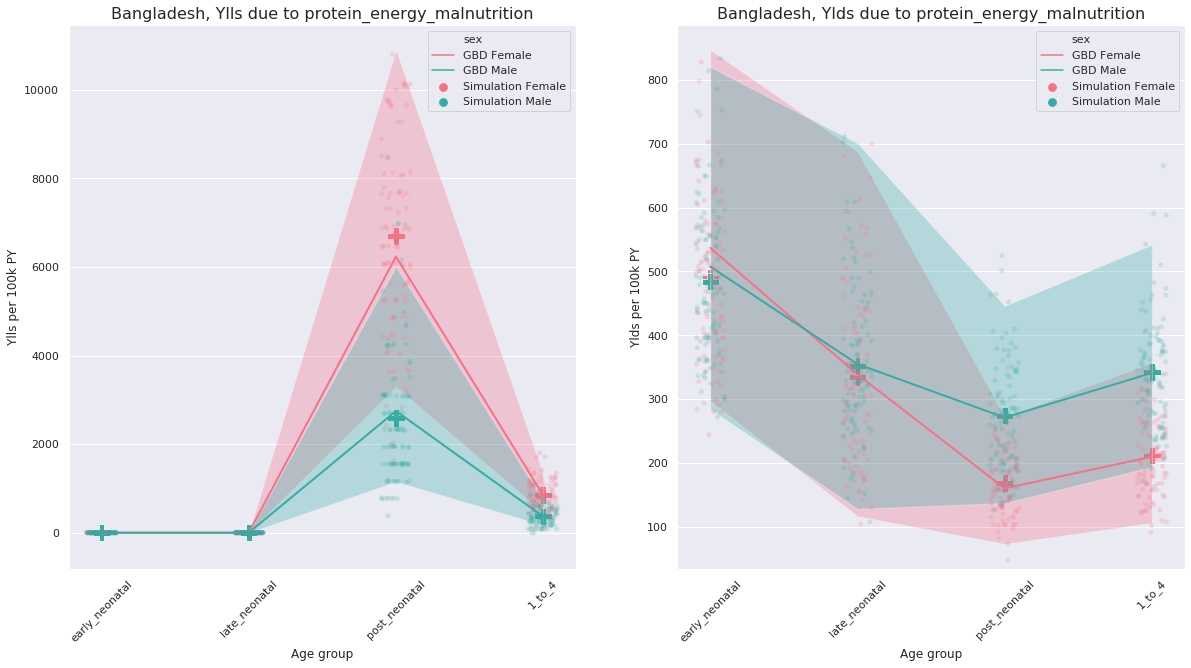

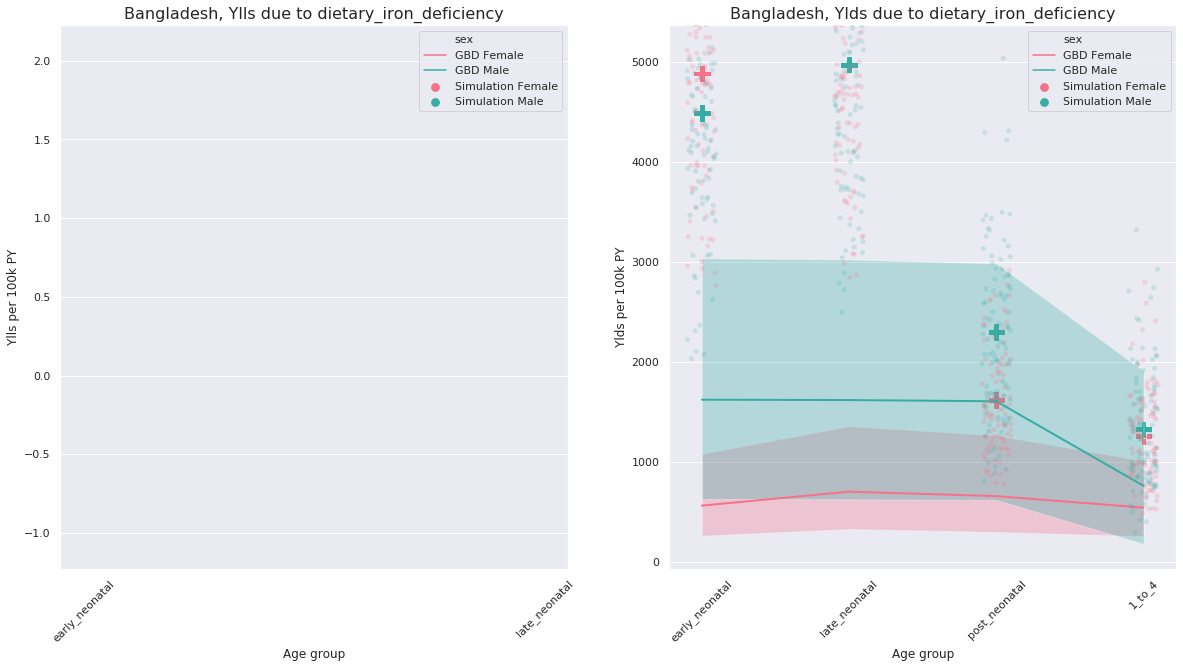

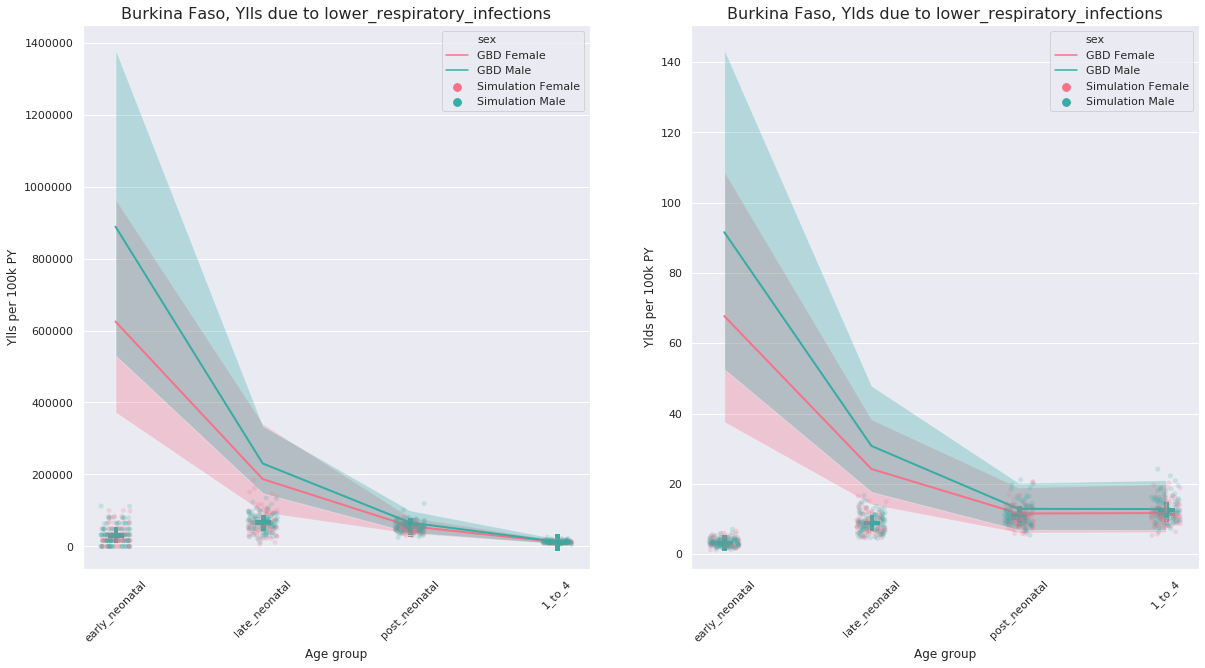

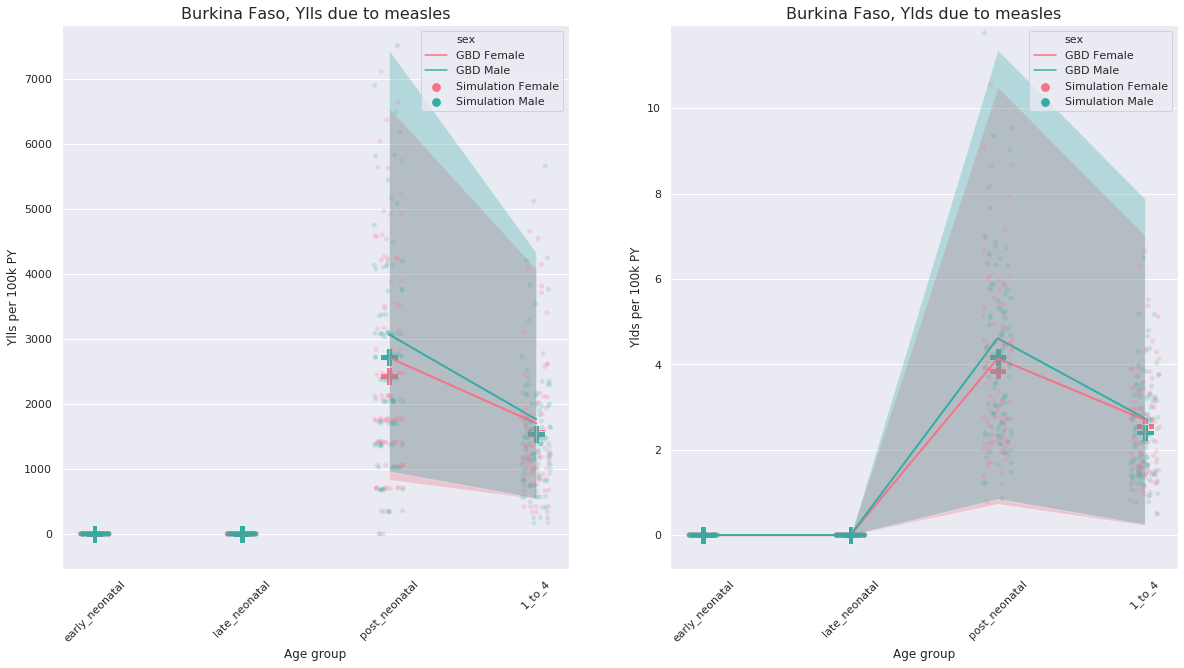

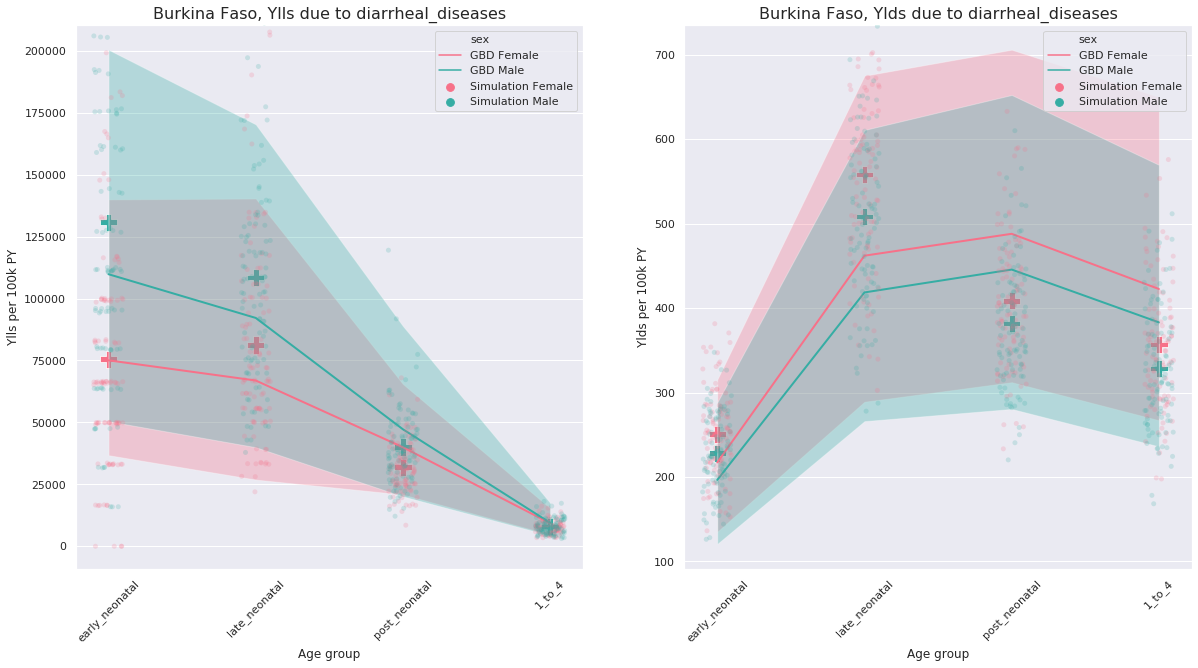

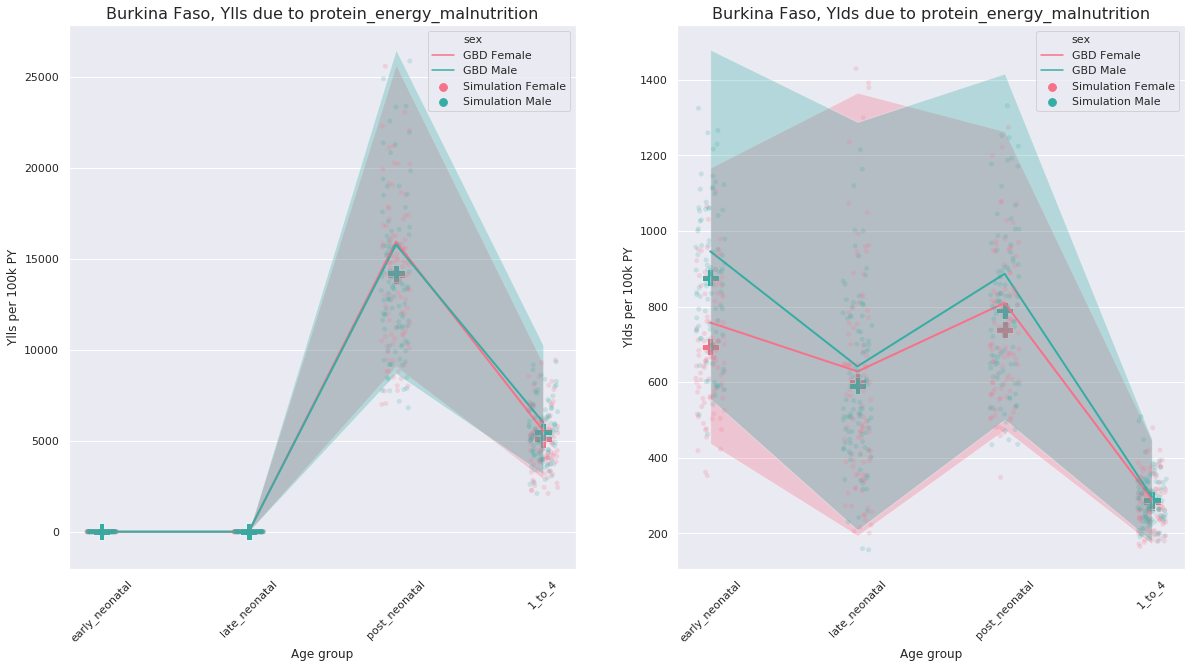

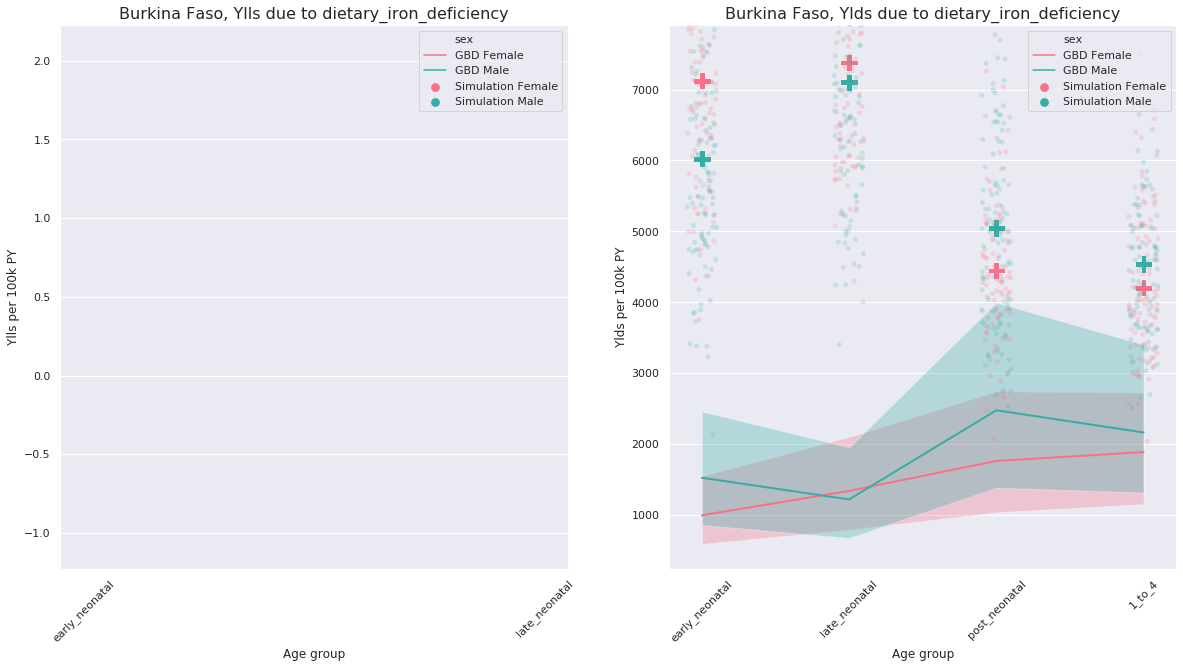

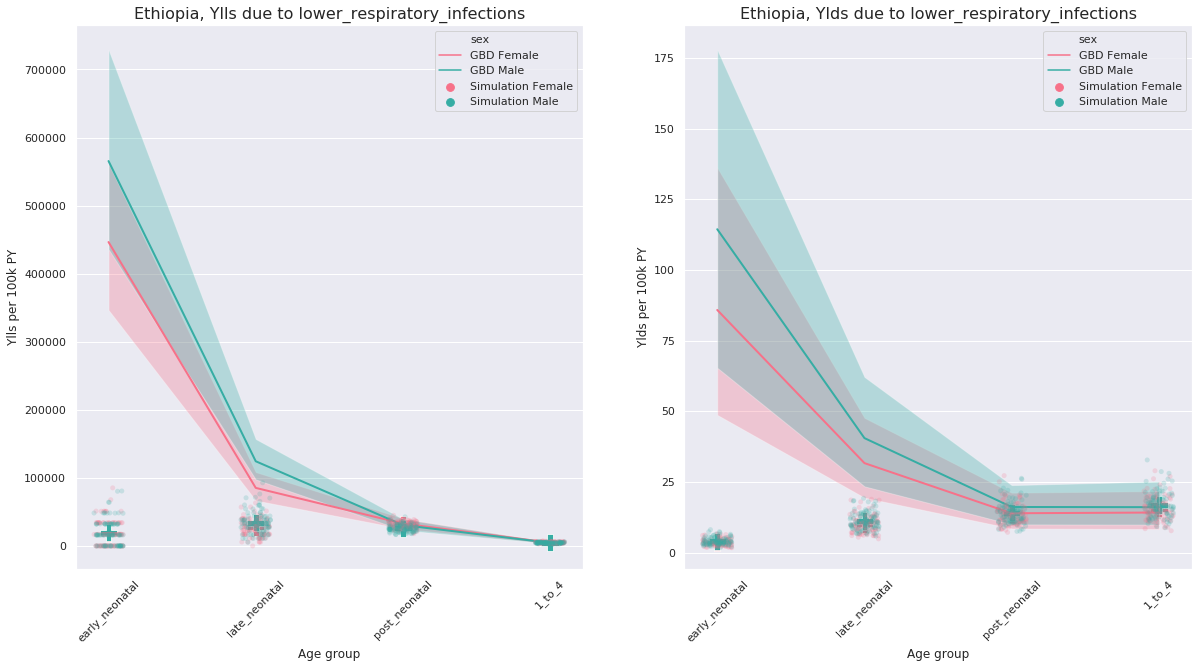

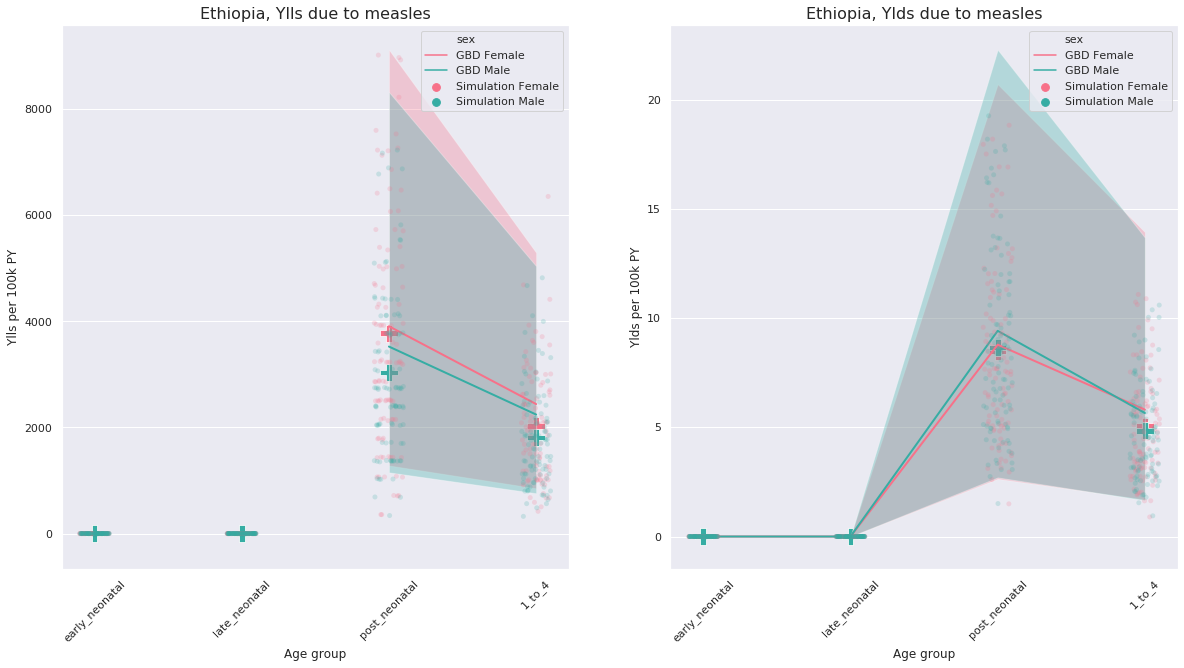

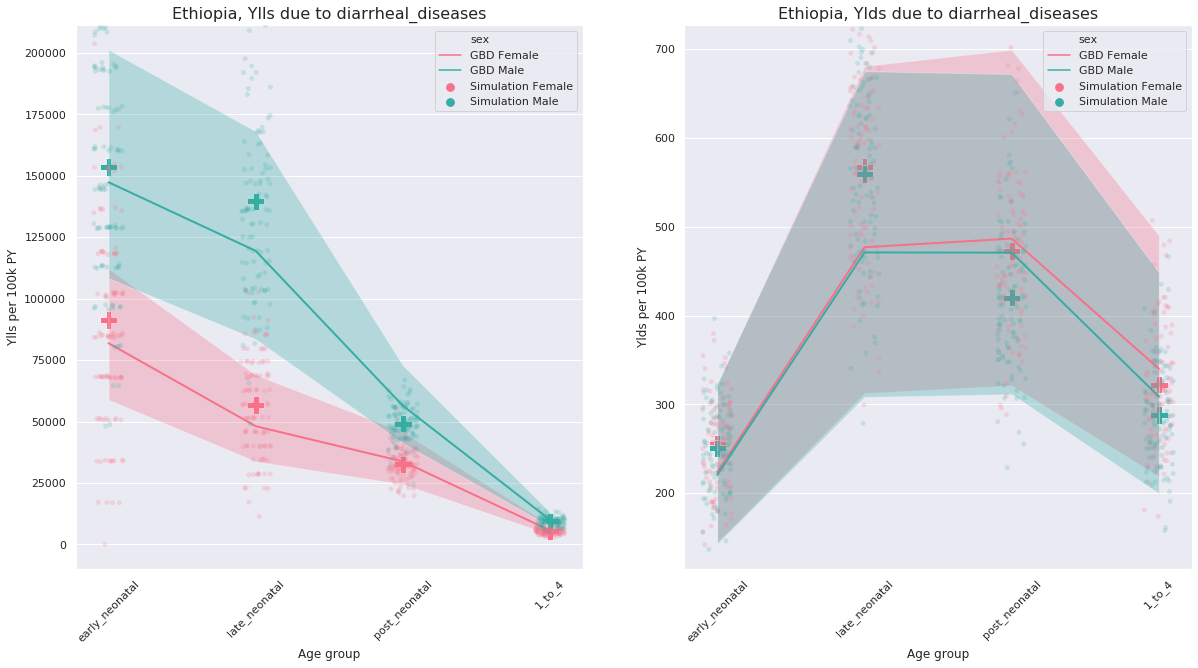

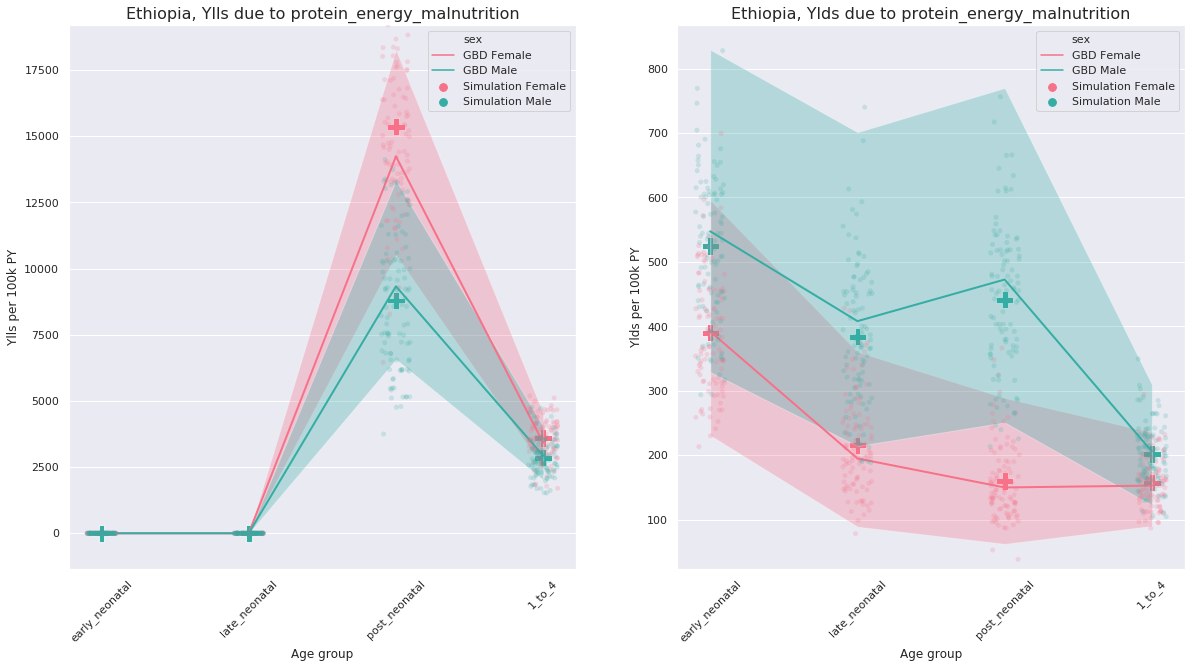

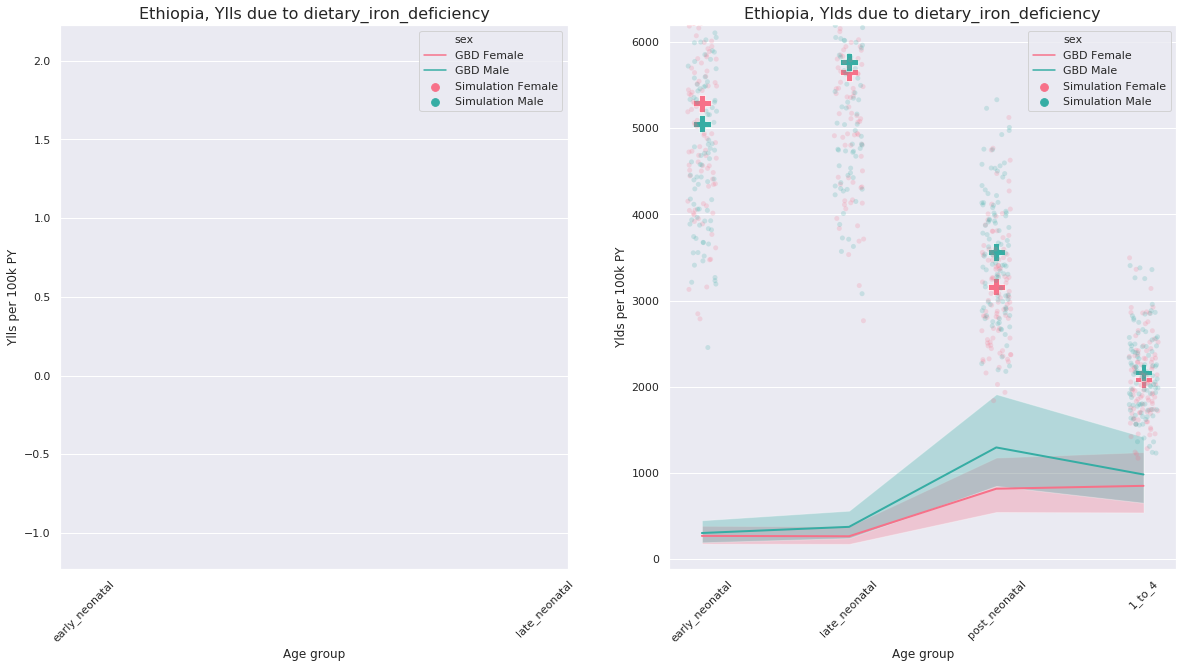

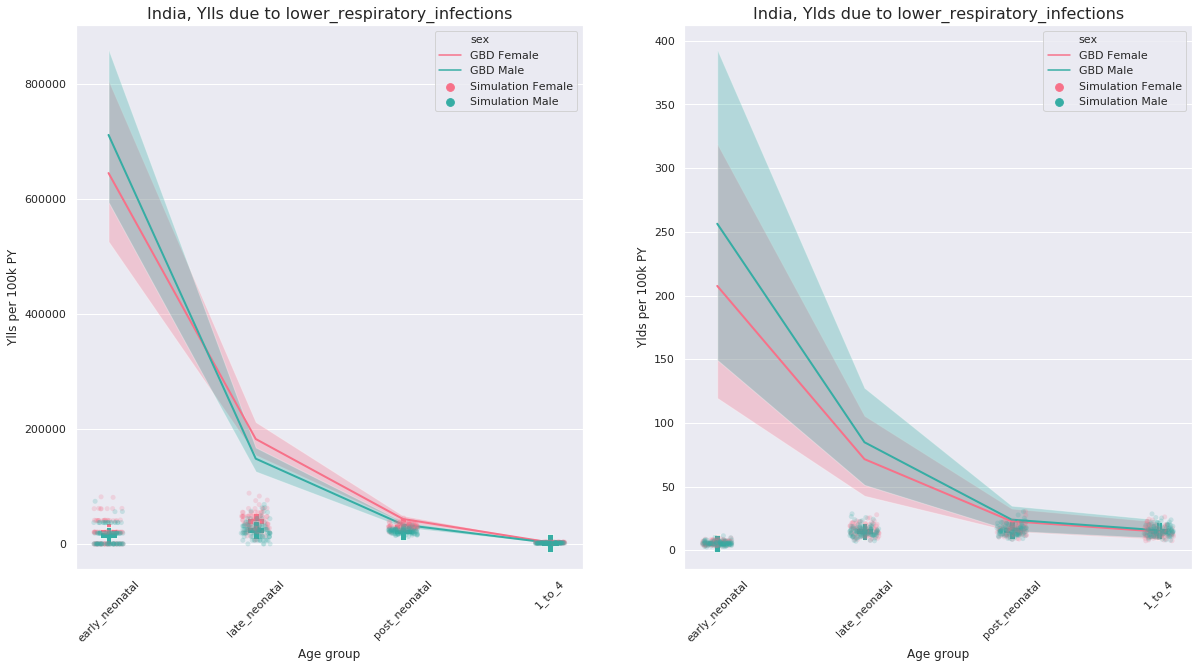

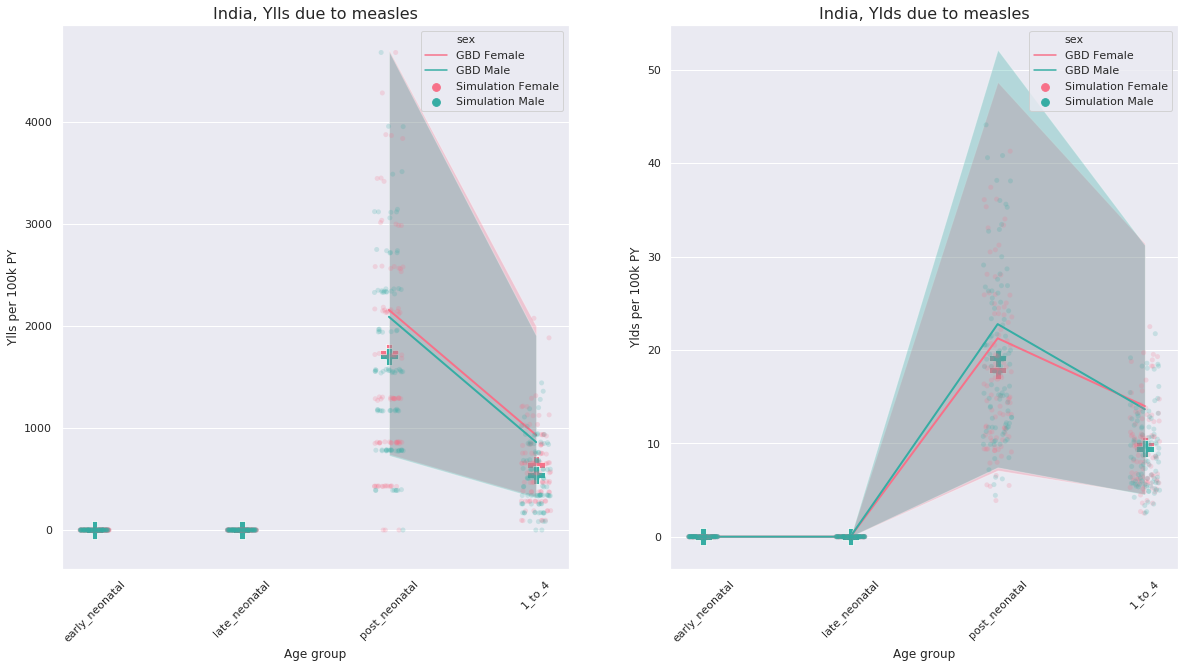

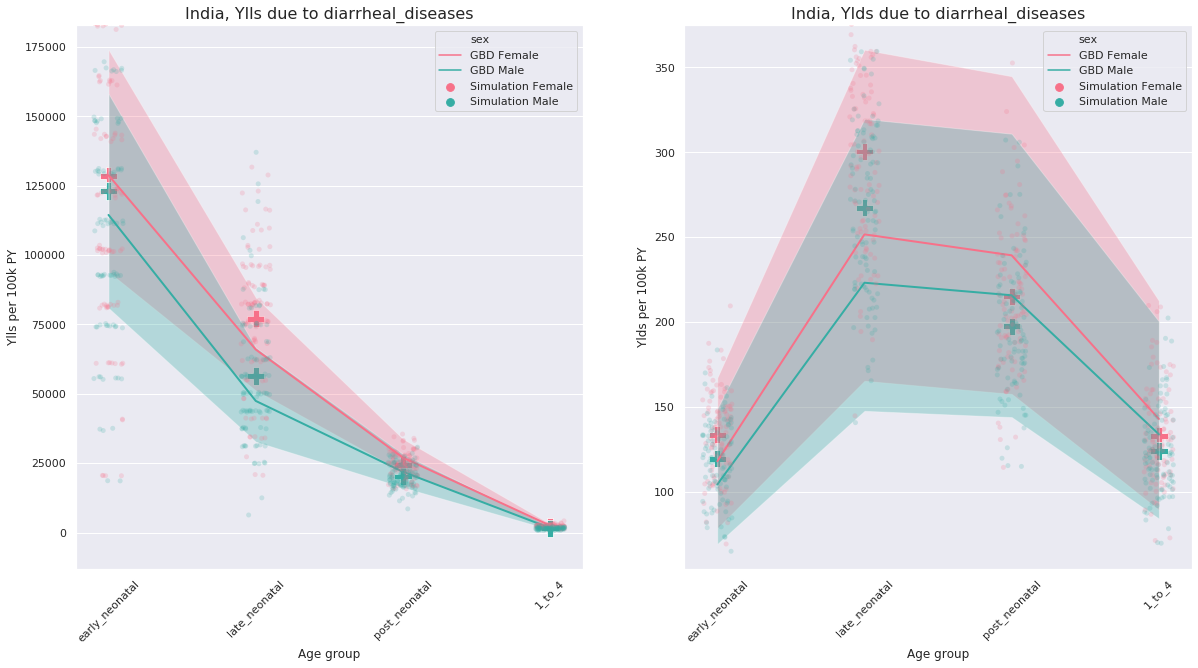

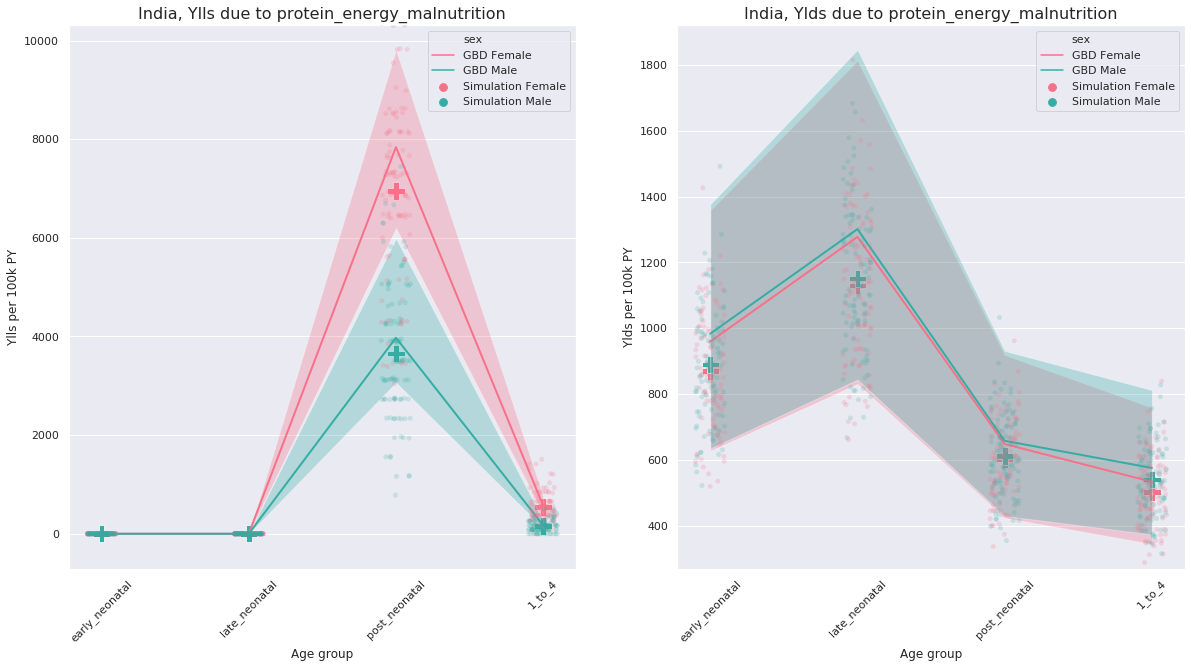

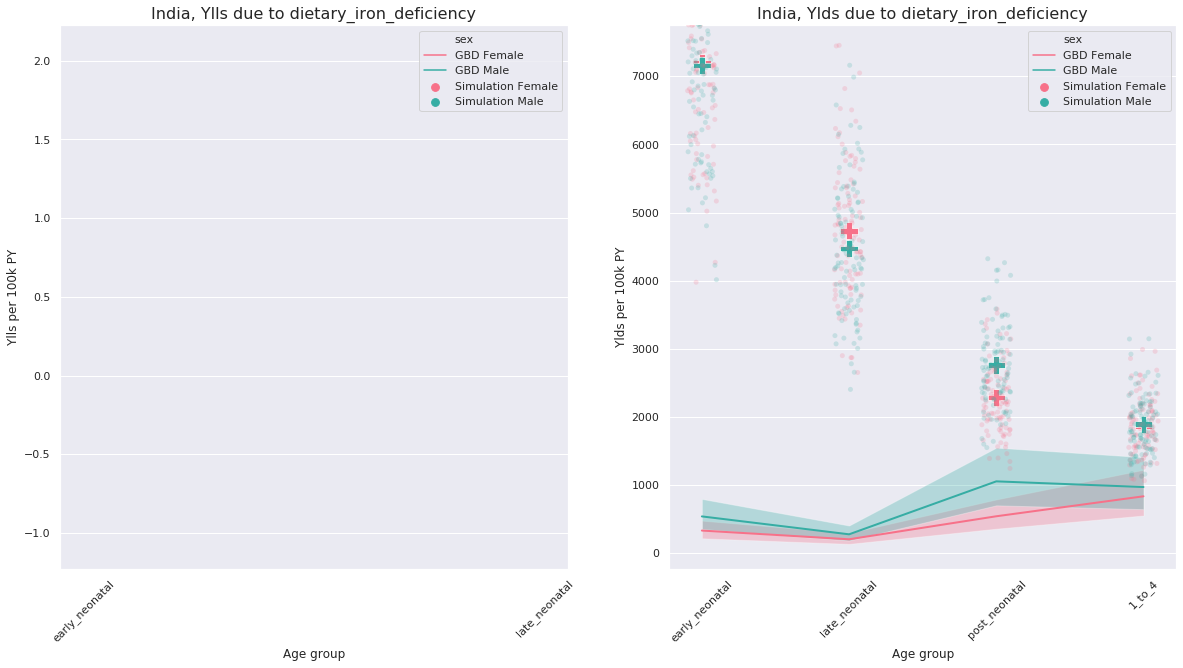

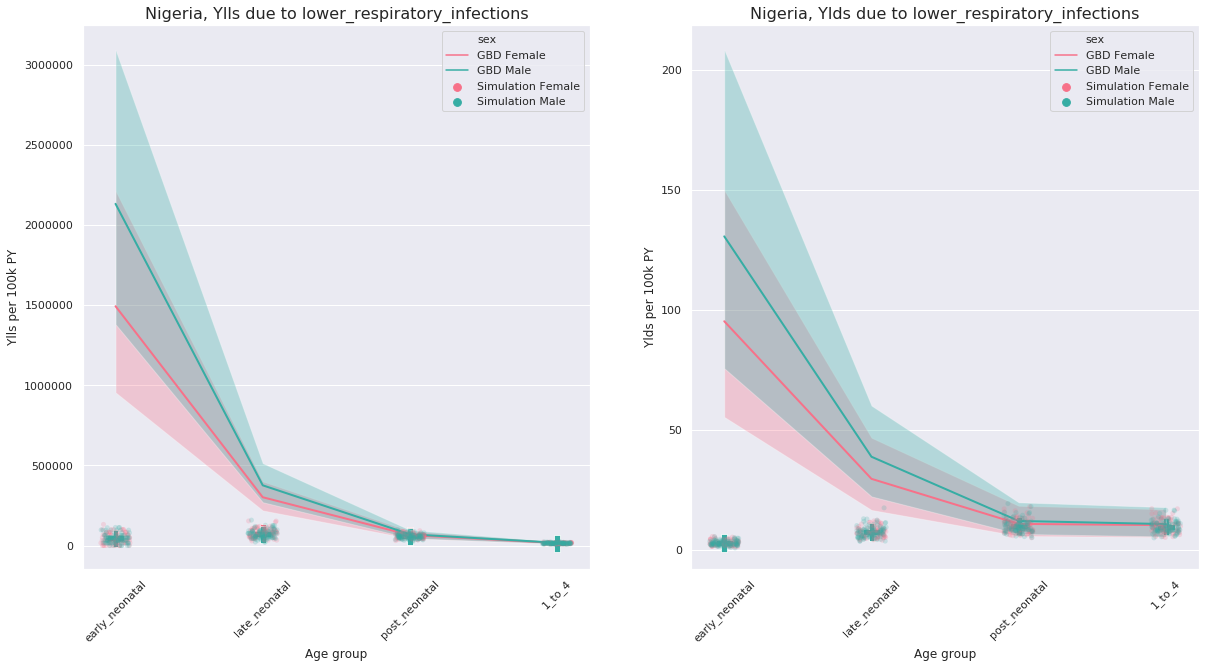

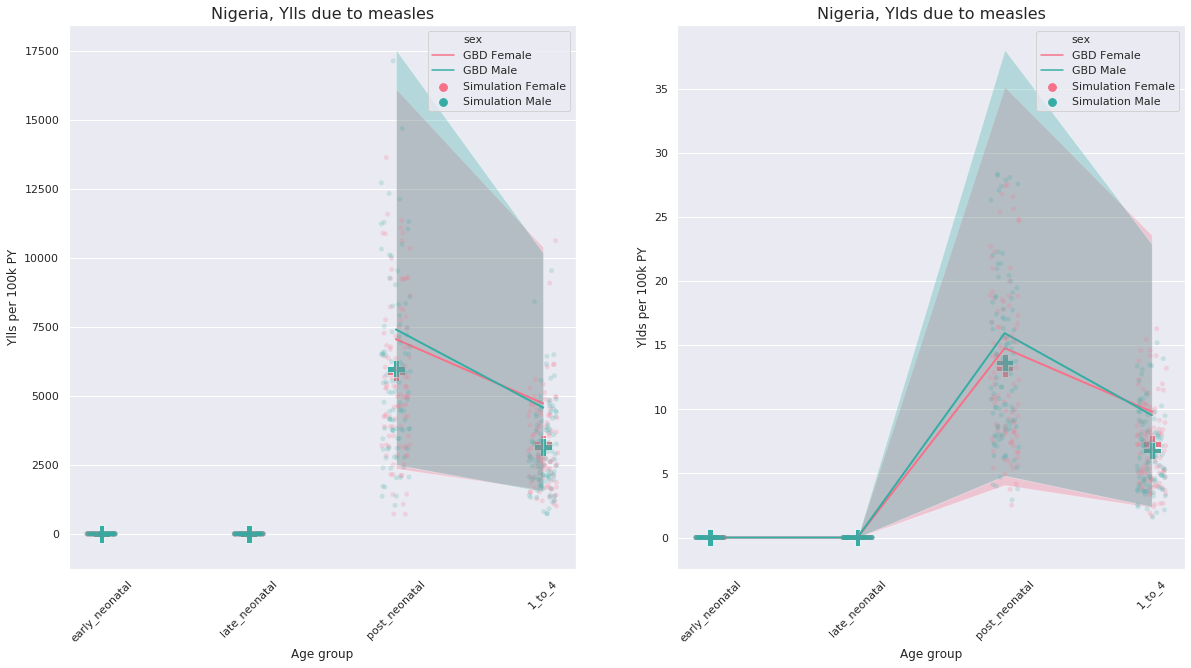

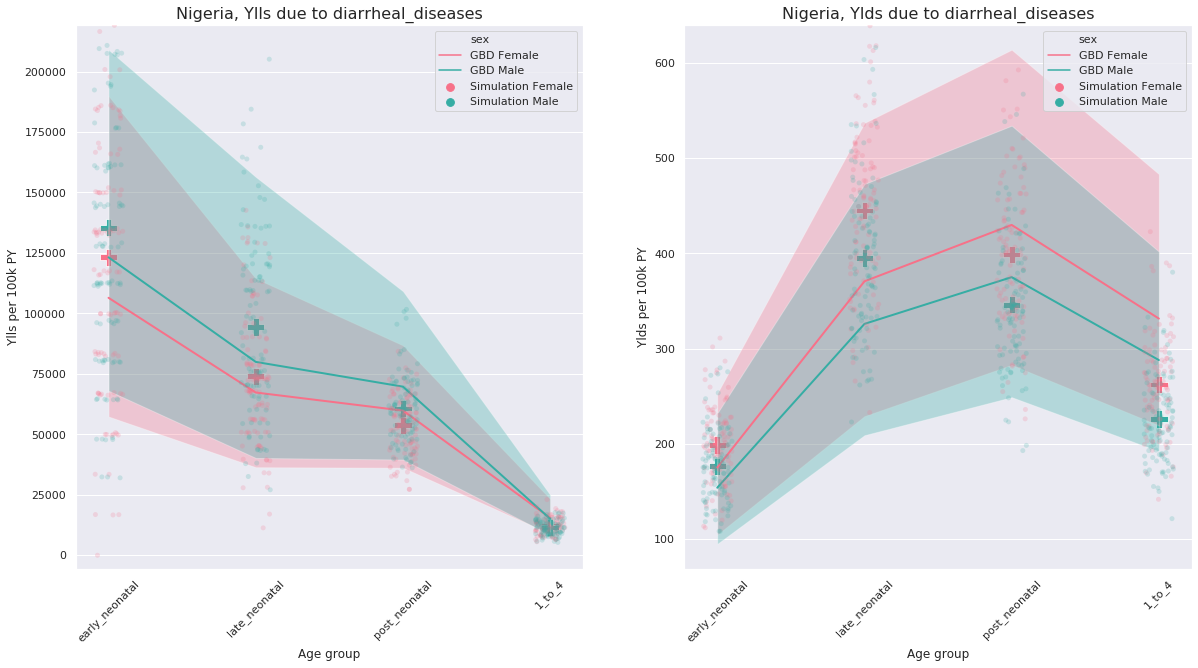

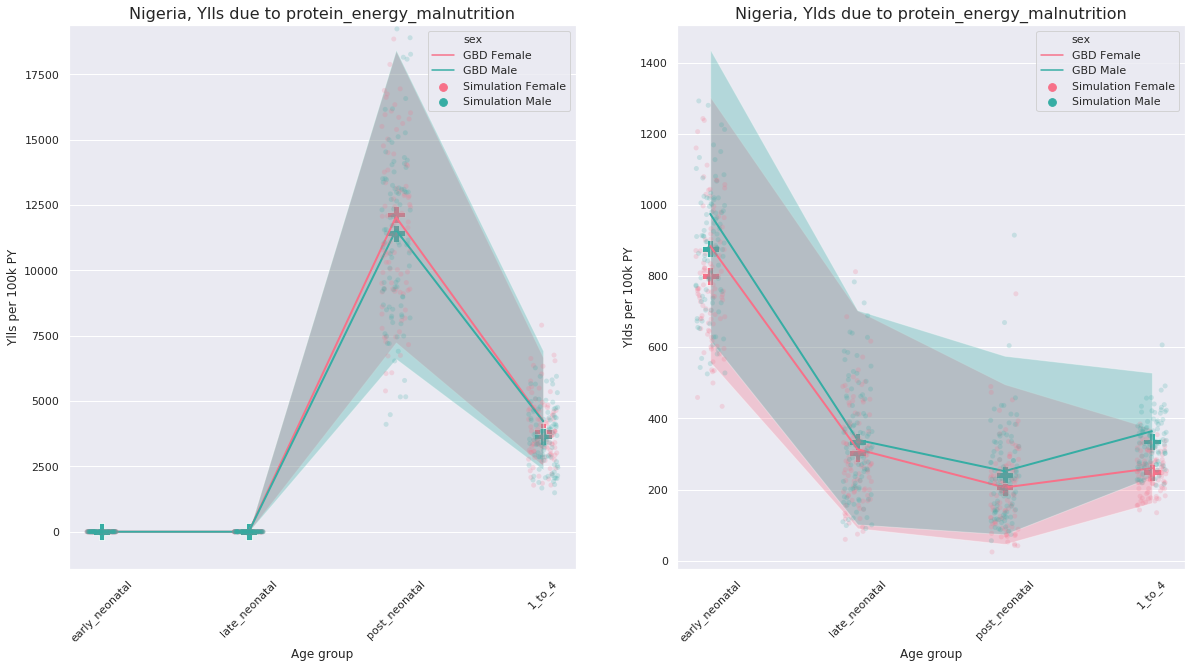

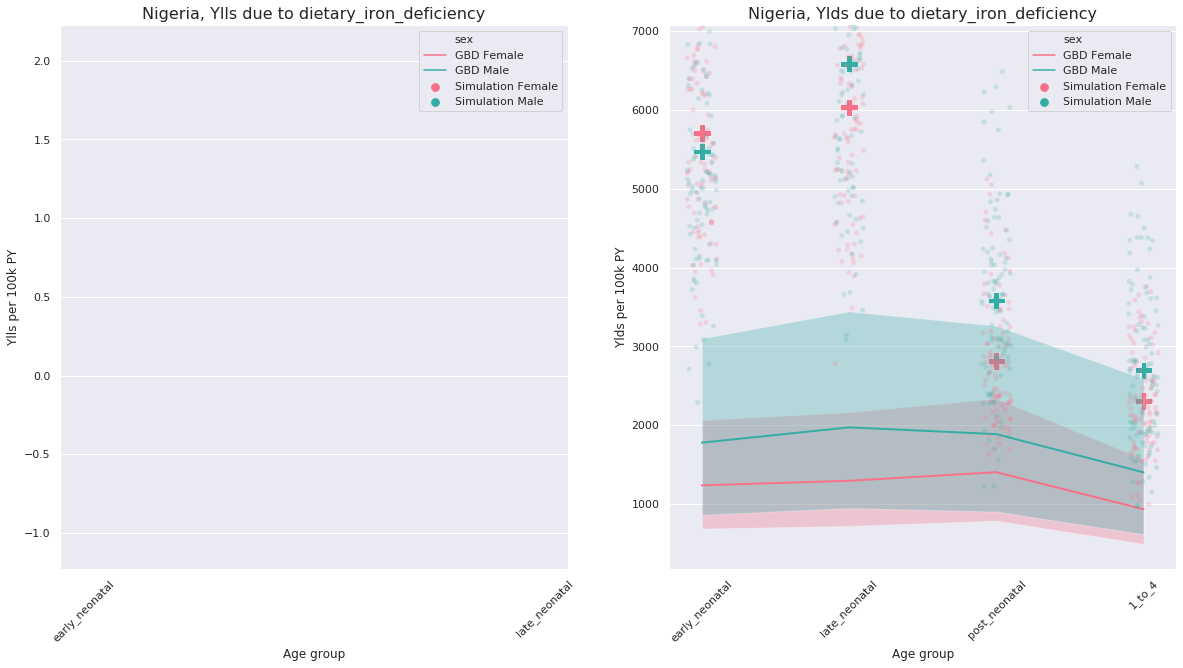

In [11]:
plot_multiple_locations(path_for_location, cause_names)